<a href="https://colab.research.google.com/github/TadieB/pytorch-collab/blob/main/DeepNN_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# if imports fail, uncomment and run the commands below

# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


# Download The Data

In [3]:
dataset = MNIST(root = 'data/',
                download =True,
                transform=ToTensor())

# Splitting the Dataset

In [4]:
val_size = 10000
train_size = len(dataset)-val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds),len(val_ds)

(50000, 10000)

In [5]:
batch_size = 128

In [6]:
train_loader = DataLoader(train_ds,batch_size, shuffle=True,num_workers=2,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size*2, shuffle=True,num_workers=2,pin_memory=True)

In [7]:
for images, _ in train_loader:
  print('images.shape',images.shape)
  break

images.shape torch.Size([128, 1, 28, 28])


images.shape torch.Size([128, 1, 28, 28])


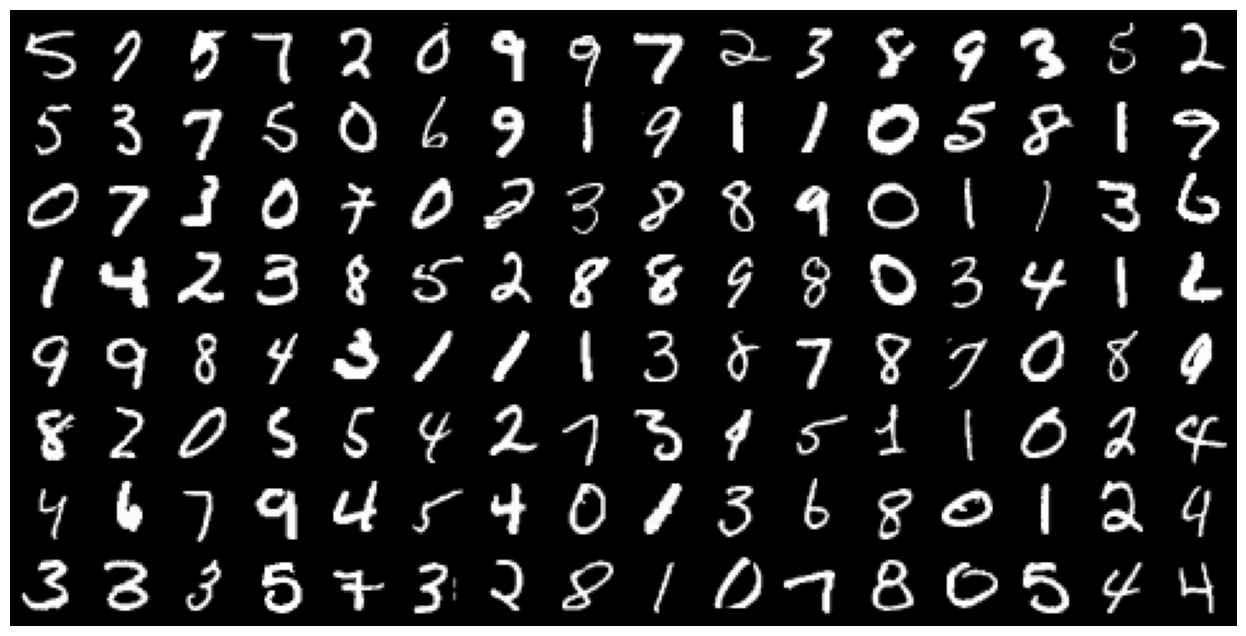

In [8]:
for images, _ in train_loader:
  print('images.shape',images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
  break

# Model

+ each of nn.Layer object is caalled a layer in the nn.
+ input layer batch_size x 784, input matrix.
+ first layer(hidden layer) batch_size x hidden_size. hidden_size preconfigued parameter e.g 32, 64 or ...
+ Then passed to non-linear activation function,
+ the result of  activation batch_size x hidden_size, is passed into 2nd layer, output layer which transforms it into
+ a matrix of size batch_size x 10,
+ one hidden layer can introduce: complexity, non-linear relationship b/n inputs &targes

In [9]:
def model(xb):
  return xb @ w.t()+b

# init
# self.linear1 = nn.Linear(28*28,16)
# self.linear2 = nn.Linear(16,10)

# forward():
#   out = self.linear1(xb)
#   out = F.relu(out)
#   out = self.linear2(out)
#   return out

# out = (xb @ w1 + b1) @ w2 + b2 = xb @ ((w1 @ W2)+(b1@w1) )+b2 =  xb @ w3 + b2= self.liner3(xb)

In [10]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [11]:
class MnistModel(nn.Module):
  ''' Feedforward neual network with 1 hidden layer'''
  def __init__(self,in_size, hidden_size, out_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(in_size,hidden_size)
    # output layer
    self.linear2 = nn.Linear(hidden_size,out_size)

  def forward(self, xb):
    # Flatten the image tensors
    xb = xb.view(xb.size(0),-1) #size(0), 0 is first dimension or batch size
    # Get intermediate outputs using hidden layer
    out = self.linear1(xb)
    # Apply activation function
    out = F.relu(out)
    # Get pedictions using output layer
    out = self.linear2(out)
    return out

  def training_step(self, batch):
    images,labels = batch
    out = self(images) # Generate predictions
    loss = F.cross_entropy(out, labels) # calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images) # Generate predictions
    loss = F.cross_entropy(out,labels)#calculate loss
    acc = accuracy(out, labels) # calculate accuracy
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() # combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() #combine accuracies
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['val_loss'],result['val_acc']))


In [12]:
input_size = 784
hidden_size = 32 # can be 64 or ...
num_classes = 10


In [13]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [14]:
model

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [15]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


# Try the Model with Only the First Batch

+ 128 images

In [16]:
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss:', loss.item())
  break

print('outputs.shape:',outputs.shape)
print('Sample.outputs:',outputs[:2].data)

# train_loader shuffel, and split images/traing sets in batches
# for loop first pass is first batch, 2nd pass 2nd batch
# so if there is break only first batch is done.

Loss: 2.319819927215576
outputs.shape: torch.Size([128, 10])
Sample.outputs: tensor([[ 0.0394,  0.0819, -0.0258,  0.0431, -0.0014, -0.0209,  0.0659, -0.1776,
          0.2411, -0.0726],
        [-0.2206,  0.0957,  0.0052,  0.1156,  0.0079, -0.0975, -0.0155, -0.0999,
          0.1707, -0.1416]])


# Using a GPU

In [17]:
# CHECK IF A gpu is available and the required NVIDIA CUDA dives ae installed

torch.cuda.is_available()

False

+ If GPU available, use GPUT. Otherwise, use defaults (CPU)

In [18]:
def get_default_device():
  '''Pick GPU if available, else CPU'''
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [19]:
device = get_default_device()
device

device(type='cpu')

+ Move Data and Model to a Chosen Device

In [20]:
def to_device(data, device):
  '''Move tensor(s) to chosen device'''
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

# This function takes data (a tensor or a list/tuple of tensors) and device as input.
# If data is a list or tuple, it recursively applies to_device to each element of the container.
# If data is a tensor, it moves the tensor to the specified device using data.to(device, non_blocking=True).
# The non_blocking=True argument in to_device() makes the data transfer asynchronous,

In [21]:
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
 # print(images)
  break

torch.Size([128, 1, 28, 28])
cpu


+ Define a Class to Wrap our existing data loaders and move dat to selected device


In [22]:
class DeviceDataLoader():
  ''' wrap a dataloader to move data to a device'''
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    '''Yield a batch of data after moving it to device'''
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    '''Number of batches'''
    return len(self.dl)

In [23]:
train_loader = DeviceDataLoader(train_loader,device)
val_loader = DeviceDataLoader(val_loader,device)

+ Tensors that have been moved to the GPU'S RAM have a device property which includes the word 'cuda'.
+ Let's verify this by looking at a batch of data from valid_dl.

In [24]:
for xb, yb in val_loader:
  print('xb.Device:', xb.device)
  print('yb:',yb)
  break

xb.Device: cpu
yb: tensor([4, 7, 7, 5, 5, 0, 7, 9, 0, 6, 3, 5, 8, 9, 1, 3, 9, 5, 8, 2, 2, 8, 9, 7,
        7, 7, 1, 3, 8, 0, 3, 4, 1, 3, 5, 8, 7, 8, 7, 8, 7, 7, 6, 5, 9, 8, 9, 9,
        1, 1, 2, 3, 5, 7, 5, 9, 9, 4, 5, 3, 1, 6, 1, 3, 4, 0, 6, 1, 4, 6, 7, 6,
        0, 2, 4, 6, 7, 0, 8, 3, 2, 5, 1, 0, 5, 6, 5, 6, 1, 0, 8, 7, 6, 8, 4, 3,
        0, 8, 9, 7, 1, 5, 8, 3, 5, 1, 0, 1, 0, 3, 6, 1, 8, 7, 5, 5, 2, 9, 1, 1,
        4, 6, 9, 8, 9, 2, 6, 0, 1, 9, 2, 7, 7, 7, 6, 4, 1, 2, 4, 3, 4, 7, 9, 0,
        7, 5, 4, 5, 0, 9, 1, 2, 4, 2, 6, 2, 5, 1, 9, 5, 9, 8, 6, 6, 9, 6, 4, 0,
        4, 3, 1, 1, 0, 1, 6, 2, 1, 0, 5, 5, 1, 9, 4, 4, 5, 9, 4, 3, 1, 2, 5, 3,
        7, 8, 4, 7, 4, 7, 3, 5, 2, 9, 1, 5, 3, 3, 3, 1, 1, 6, 8, 4, 0, 6, 8, 7,
        5, 2, 5, 5, 9, 8, 3, 1, 6, 7, 6, 3, 2, 1, 2, 0, 5, 8, 5, 8, 7, 6, 0, 8,
        9, 5, 7, 2, 8, 6, 9, 2, 4, 1, 4, 0, 6, 7, 0, 3])


# Trining the **Model**

In [25]:

def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    # Training phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #Validation phase
    result = evaluate(model,val_loader)
    model.epoch_end(epoch,result)
    history.append(result)
  return history


+ Before training encure data&model parameters are on the same device (cpu/gpu)

In [26]:
model = MnistModel(input_size, hidden_size=hidden_size,out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

# Initial Loss & Validation Results

+ it has a 1 in 10 chance of getting a label right by guessing randomly.

In [27]:

restult0 = evaluate(model,val_loader)
restult0
# initial accuracy.

{'val_loss': 2.3215954303741455, 'val_acc': 0.10009765625}

# Train for 5 epochs

In [28]:
history = fit(5,0.5,model, train_loader, val_loader)

Epoch [0], val_loss: 0.2059, val_acc: 0.9393
Epoch [1], val_loss: 0.1884, val_acc: 0.9448
Epoch [2], val_loss: 0.1693, val_acc: 0.9535
Epoch [3], val_loss: 0.1401, val_acc: 0.9590
Epoch [4], val_loss: 0.1438, val_acc: 0.9589


# Train for 5 more epochs

+ with lower learning rate

In [29]:
history = fit(5,0.5,model, train_loader, val_loader)

Epoch [0], val_loss: 0.1186, val_acc: 0.9659
Epoch [1], val_loss: 0.1373, val_acc: 0.9599
Epoch [2], val_loss: 0.1138, val_acc: 0.9654
Epoch [3], val_loss: 0.1254, val_acc: 0.9646
Epoch [4], val_loss: 0.1392, val_acc: 0.9642


In [34]:
history = fit(5,0.1,model, train_loader, val_loader)

Epoch [0], val_loss: 0.1106, val_acc: 0.9683
Epoch [1], val_loss: 0.1159, val_acc: 0.9667
Epoch [2], val_loss: 0.1094, val_acc: 0.9680
Epoch [3], val_loss: 0.1104, val_acc: 0.9678
Epoch [4], val_loss: 0.1132, val_acc: 0.9663


# Plotting Losses & Accuracies

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Loss vs No. of epochs')

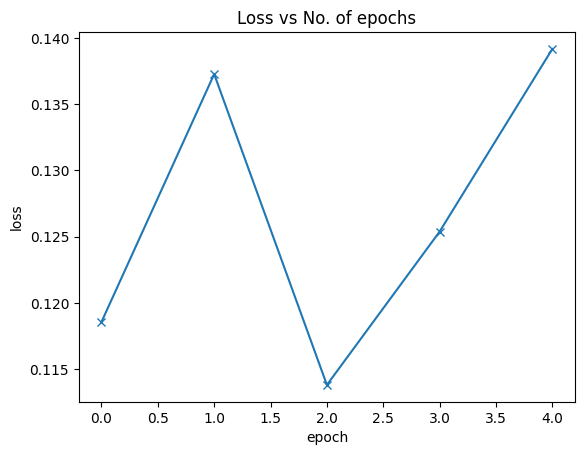

In [31]:
losses = [x['val_loss'] for x in history]
plt.plot(losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs No. of epochs')

In [32]:
history

[{'val_loss': 0.1185511127114296, 'val_acc': 0.9659179449081421},
 {'val_loss': 0.13727888464927673, 'val_acc': 0.9598633050918579},
 {'val_loss': 0.11380213499069214, 'val_acc': 0.9654296636581421},
 {'val_loss': 0.1253838986158371, 'val_acc': 0.964550793170929},
 {'val_loss': 0.13918085396289825, 'val_acc': 0.964160144329071}]

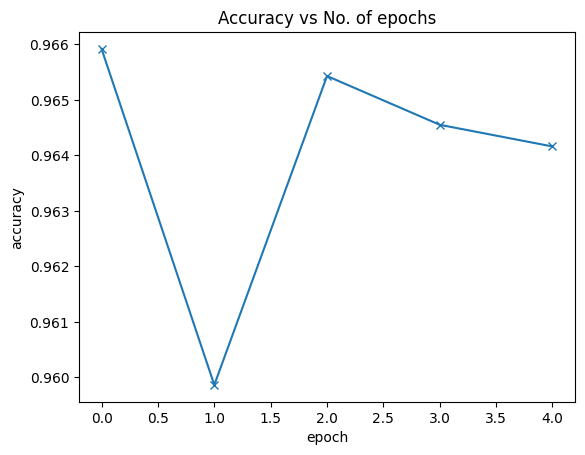

In [33]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs');

+ increase the datasets
+ increase the hidden layers
+ will impove accuracies more.
+ DNN is better than logistic Reg though

# Prediction on Samples

In [37]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=ToTensor())

+ After applying unsqueeze(0), a batch dimension is added at position 0,

In [41]:
# def predict_image(img,model):
#   xb = to_device(img.unsqueeze(0),device)
#   yb = model(xb)
#   _,preds = torch.max(yb,dim=1)
#   return preds[0].item()

In [40]:
# img, label = test_dataset[0]
# plt.imshow(img[0],cmap='gray')
# print('Label:', dataset.classes[label],', Predicted:',dataset.classes[predict_image(img)])

Original Tensor: torch.Size([3])
Tensor with Batch Dimension: torch.Size([1, 3])
